<a href="https://colab.research.google.com/github/jtfreitas/NN_DL/blob/main/HW2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q optuna
!wget -O vae_tools.py https://raw.githubusercontent.com/jtfreitas/NN_DL/main/HW2/vae_tools.py

     |████████████████████████████████| 308 kB 5.1 MB/s 
     |████████████████████████████████| 209 kB 69.8 MB/s 
     |████████████████████████████████| 81 kB 9.8 MB/s 
     |████████████████████████████████| 78 kB 8.3 MB/s 
     |████████████████████████████████| 146 kB 38.9 MB/s 
     |████████████████████████████████| 49 kB 7.1 MB/s 
     |████████████████████████████████| 112 kB 72.5 MB/s 
--2022-07-07 18:26:07--  https://raw.githubusercontent.com/jtfreitas/NN_DL/main/HW2/vae_tools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19092 (19K) [text/plain]
Saving to: ‘vae_tools.py’

vae_tools.py        100%[===================>]  18.64K  --.-KB/s    in 0.001s  

2022-07-07 18:26:07 (18.9 MB/s) - ‘vae_tools.py’ saved [19092/19092]



In [14]:
%load_ext autoreload
%autoreload 2
import random
from tqdm import tqdm
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision import utils as vutils
import optuna

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg

#Custom module with class definitions and model training utilities
#in order to keep notebook as procedural as possible
import vae_tools as vt

seed = 69420

# Use GPU if available
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Device in use: {device}")

random.seed(seed)
torch.manual_seed(seed)
print(f"Random seed: {seed}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device in use: cuda
Random seed: 69420


In [15]:
#Load FashionMNIST datasets into memory

data_dir = 'dataset'

train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

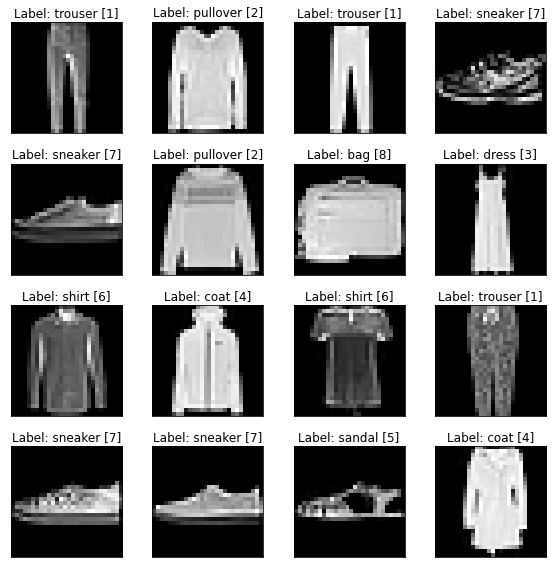

In [16]:
#Display some samples

label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(4, 4, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [17]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
MNIST_transform = transforms.Compose([
    transforms.ToTensor(),
])
### Define dataloaders
train_dataloader = DataLoader(train_dataset,
                            batch_size=256, shuffle=True, num_workers=2)
test_dataloader  = DataLoader(test_dataset,
                            batch_size=256, shuffle=False)

# Include a subset used only for hyperparameter tuning to speed up process
HP_search_subset = torch.utils.data.Subset(train_dataset,
                                           list(range(len(train_dataset)//5 )))
HP_search_dataloader = DataLoader(HP_search_subset,
                                  batch_size = 120, shuffle = True)


# Set the train, test and subset transform
train_dataset.transform = MNIST_transform
test_dataset.transform = MNIST_transform
HP_search_subset.transform = MNIST_transform

# Show shapes of the data for quality control
batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa89c432200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa89c432200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


In [18]:
def AE_objective(trial):
    """
    Performs a Bayesian-like hyperparameter search, using optuna's TPESampler.
    This generally allows a more thorough search compared to completely random
    sampling methods, while saving computation time compared to a complete grid
    search, especially considering the large range of filters considered.
    Overall, it's a good compromise between the certainty of grid-search and
    the efficiency of a random search.

    The best model is chosen based on the test data loss after five epochs.
    """

    # Parameters in the search include number of filters, size of the first
    # dense layer, shape of latent space, optimizer type, and finally its 
    # respective learning rate.

    params = {
        'conv1': {'filters': trial.suggest_int('filters1', 16, 32),
                  'kernel': 3,
                  'stride': 2,
                  'padding': 1},
        'conv2': {'filters': trial.suggest_int('filters2', 64, 128),
                  'kernel': 3,
                  'stride': 2,
                  'padding': 1},
        'conv3': {'filters': trial.suggest_int('filters3', 256, 512),
                  'kernel': 3,
                  'stride': 2,
                  'padding': 0},
        'lin1': trial.suggest_int('lin1', 32, 128),
        'latent_space': trial.suggest_int('latent_space', 2, 16)
    }

    model = vt.Autoencoder(28, params, device, keep_loss=False)
    model.to(device)

    lr = trial.suggest_loguniform('lr', 1e-5, 5e-4)
    params_to_optimize = [
        {'params': model.parameters()},
    ]
    optim_type = trial.suggest_categorical(
        'optimizer', ['Adam', 'Adagrad', 'RMSprop'])
    optim = getattr(torch.optim, optim_type)(params_to_optimize, lr=lr)
    loss_fn = torch.nn.MSELoss()
    best_loss = vt.train_AE(
        model, 5, HP_search_dataloader, loss_fn, optim, device, verbose=False
        )[0] 
    # Choose only the [0]th element returned by train_AE, second corresponds
    # to the training epoch of the lowest loss.

    return best_loss

In [19]:
study = optuna.create_study(direction='minimize') #Goal is to minimize the loss
study.optimize(AE_objective, n_trials = 20)     #20 different models are tested

[I 2022-07-07 20:17:03,996] A new study created in memory with name: no-name-ca8c3c14-f05d-4024-adea-d6473404f85a
[I 2022-07-07 20:17:13,184] Trial 0 finished with value: 0.04135814309120178 and parameters: {'filters1': 25, 'filters2': 70, 'filters3': 447, 'lin1': 57, 'latent_space': 13, 'lr': 0.0001016335183937195, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.04135814309120178.
[I 2022-07-07 20:17:19,607] Trial 1 finished with value: 0.07033739984035492 and parameters: {'filters1': 25, 'filters2': 108, 'filters3': 482, 'lin1': 36, 'latent_space': 12, 'lr': 0.0002933466310184678, 'optimizer': 'Adagrad'}. Best is trial 0 with value: 0.04135814309120178.
[I 2022-07-07 20:17:25,970] Trial 2 finished with value: 0.21324841678142548 and parameters: {'filters1': 25, 'filters2': 110, 'filters3': 321, 'lin1': 98, 'latent_space': 8, 'lr': 2.1218272318877337e-05, 'optimizer': 'Adagrad'}. Best is trial 0 with value: 0.04135814309120178.
[I 2022-07-07 20:17:32,508] Trial 3 finished with 

In [20]:
#Grab the best model parameters from the study
best_params = study.best_params

#Format the parameters according to the structure of the autoencoder
best_params = {
    'conv1': {'filters': study.best_params['filters1'],
                'kernel': 3,
                'stride': 2,
                'padding': 1},
    'conv2': {'filters': study.best_params['filters2'],
                'kernel': 3,
                'stride': 2,
                'padding': 1},
    'conv3': {'filters': study.best_params['filters3'],
                'kernel': 3,
                'stride': 2,
                'padding': 0},
    'lin1': study.best_params['lin1'],
    'latent_space': study.best_params['latent_space']
}

#Instantiate the autoencoder, set up torch loss and optimizer
best_AE = vt.Autoencoder(28, best_params, device)

loss_fn = torch.nn.MSELoss()
params_to_optimize = [
    {'params': best_AE.parameters()},
]
optim = torch.optim.Adam(params_to_optimize, lr=study.best_params['lr'],
                         weight_decay=1e-5)

best_AE.to(device)
loss_fn.to(device)

MSELoss()

In [21]:
no_epochs = 20
#Save model to ./best_AE_z[...]
best_loss, best_epoch = vt.train_AE(
        best_AE, no_epochs, train_dataloader, loss_fn, optim, device,
        test_dataloader=test_dataloader,
        save_dir = f'best_AE_z{best_AE.latent_space}')

EPOCH 1/20 : 
partial train loss (single batch): 0.023565partial train loss (single batch): 0.023565	Validation loss: 0.024564
EPOCH 2/20 : 
partial train loss (single batch): 0.020279partial train loss (single batch): 0.020279	Validation loss: 0.020048
EPOCH 3/20 : 
partial train loss (single batch): 0.017995partial train loss (single batch): 0.017995	Validation loss: 0.018372
EPOCH 4/20 : 
partial train loss (single batch): 0.017713partial train loss (single batch): 0.017713	Validation loss: 0.016729
EPOCH 5/20 : 
partial train loss (single batch): 0.015352partial train loss (single batch): 0.015352	Validation loss: 0.015727
EPOCH 6/20 : 
partial train loss (single batch): 0.015018partial train loss (single batch): 0.015018	Validation loss: 0.014969
EPOCH 7/20 : 
partial train loss (single batch): 0.012587partial train loss (single batch): 0.012587	Validation loss: 0.014419
EPOCH 8/20 : 
partial train loss (single batch): 0.013747partial train loss (single batch): 0.013747	Validation

[autoreload of vae_tools failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/content/vae_tools.py", line 576
    x_batch, start_dim=1)
                        ^
SyntaxError: invalid syntax
]


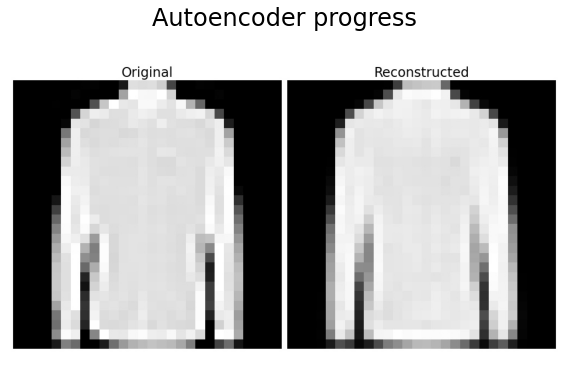

In [22]:
def read_img(i):
    """
    Handles the exception caused by plots that were not saved because the
    model performance worsened on the respective epoch.
    """
    try:
        return mpimg.imread(f'best_AE_z{best_AE.latent_space}/plots/t={i}.jpg')
    except FileNotFoundError:
        return None

fig = plt.figure(figsize=(8,6), tight_layout='pad')
fig.suptitle('Autoencoder progress', fontsize=24)
plt.axis("off")
img_list = [read_img(i) for i in range(1, no_epochs+1)]

#Checks if element in img_list is an array, skips it in case it isn't.
ims = [[plt.imshow(i, animated=True)] 
       for i in img_list if type(i) == np.ndarray]
ani = animation.ArtistAnimation(
    fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

# Supervised learning on latent space

In [51]:
class_params = {
    'lin1' : (best_AE.latent_space, 70),
    'lin2' : (70, 120),
    'lin3' : (120, 100),
    'lin4' : (100, 10),
}
class pre_encode(object):
    """
    Applies encoder on input space to transform
    dataset into latent space version
    """
    def __call__(self, sample):
        best_AE.to(torch.device('cpu'))
        best_AE.eval()
        with torch.no_grad():
            return best_AE.encoder(sample.unsqueeze(0).float())

# new_transform = transforms.Compose([transforms.ToTensor(), pre_encode()])
# train_dataset.transform = new_transform
# test_dataset.transform = new_transform


classifier = vt.Classifier(class_params, device)
classifier.to(device)

classifier_loss = nn.CrossEntropyLoss()
classifier_loss.to(device)
optimizer = torch.optim.Adam(
    classifier.parameters(), lr=1e-4, weight_decay=1e-5)
no_epochs = 40
vt.train_model(
    classifier, train_dataloader, test_dataloader,
    no_epochs, classifier_loss, optimizer, AE=best_AE)

Loss = 1.09757
Loss = 0.95215
Loss = 0.88358
Loss = 0.82316
Loss = 0.77683
Loss = 0.73962
Loss = 0.70887
Loss = 0.68749
Loss = 0.66824
Loss = 0.65170
Loss = 0.63744
Loss = 0.62637
Loss = 0.61260
Loss = 0.60303
Loss = 0.59366
Loss = 0.58728
Loss = 0.57630
Loss = 0.56923
Loss = 0.56315
Loss = 0.55590
Loss = 0.55027
Loss = 0.54505
Loss = 0.54061
Loss = 0.53323
Loss = 0.52892
Loss = 0.52449
Loss = 0.51938
Loss = 0.51648
Loss = 0.51233
Loss = 0.50938
Loss = 0.50492
Loss = 0.50393
Loss = 0.50005
Loss = 0.49600
Loss = 0.49470
Loss = 0.49128
Loss = 0.48994
Loss = 0.48628
Loss = 0.48419
Loss = 0.48117


0.48117199540138245

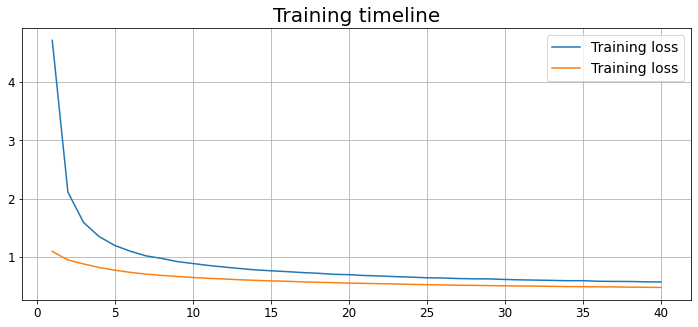

In [52]:
fig, ax = plt.subplots(1,1, figsize=(12, 5))


ax.plot(classifier.history['epoch'], classifier.history['train'],
        label='Training loss')
ax.plot(classifier.history['epoch'], classifier.history['valid'],
        label='Training loss')
ax.set_title('Training timeline', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=14)
ax.grid()

In [53]:
class_params = {
    'lin1' : (28**2, 20),
    'lin2' : (20, 120),
    'lin3' : (120, 100),
    'lin4' : (100, 10),
}

classifier_noAE = vt.Classifier(class_params, device)

classifier_noAE.to(device)
classifier_noAE_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier_noAE.parameters(), lr=1e-4, weight_decay=1e-5)
no_epochs = 40
vt.train_model(classifier_noAE, train_dataloader, test_dataloader, no_epochs, classifier_noAE_loss, optimizer)

Loss = 1.30252
Loss = 0.91044
Loss = 0.78265
Loss = 0.70797
Loss = 0.65743
Loss = 0.61594
Loss = 0.58391
Loss = 0.56090
Loss = 0.54158
Loss = 0.52865
Loss = 0.51657
Loss = 0.51165
Loss = 0.50461
Loss = 0.49581
Loss = 0.49191
Loss = 0.48311
Loss = 0.48027
Loss = 0.47750
Loss = 0.47290
Loss = 0.47042
Loss = 0.46689
Loss = 0.46341
Loss = 0.46313
Loss = 0.45946
Loss = 0.45667
Loss = 0.45419
Loss = 0.45376
Loss = 0.44938
Loss = 0.44666
Loss = 0.44513
Loss = 0.44580
Loss = 0.44569
Loss = 0.44206
Loss = 0.44007
Loss = 0.44104
Loss = 0.43768
Loss = 0.43822
Loss = 0.43641
Loss = 0.43308
Loss = 0.43518


0.43517571687698364

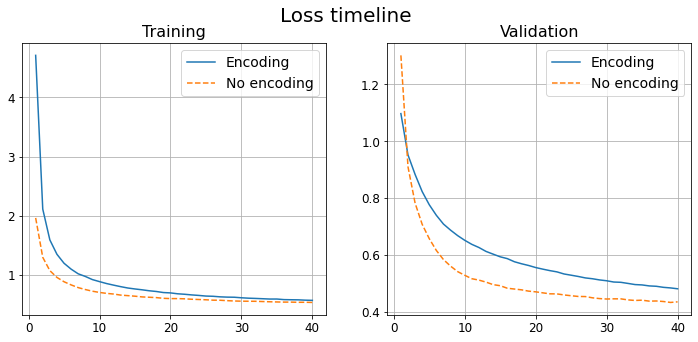

In [55]:
fig, axs = plt.subplots(1,2, figsize=(12, 5))
model_list = [classifier, classifier_noAE]
label_list = [('-', 'Encoding'), ('--', 'No encoding')]
for label, model in zip(label_list, model_list):
    axs[0].plot(model.history['epoch'], model.history['train'],
           label[0], label=label[1])
    axs[1].plot(model.history['epoch'], model.history['valid'],
        label[0], label=label[1])
    
axs[0].set_title('Training', fontsize=16)
axs[1].set_title('Validation', fontsize=16)
fig.suptitle('Loss timeline', fontsize=20)

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.legend(fontsize=14)
    ax.grid()


In [56]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
pca = PCA(n_components=2)

encoded_samples = []
for sample in test_dataset:
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    best_AE.encoder.eval()
    with torch.no_grad():
        encoded_img  = best_AE.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)

encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)

array([[ 50.87733397,  -9.33627408],
       [-22.58699709,  45.8649708 ],
       [-33.6076647 , -43.83109579],
       ...,
       [-11.98819173, -21.77688688],
       [-15.87775252, -51.58431953],
       [ 31.0072944 , -14.76684566]])

In [80]:
encoded_samples.label

0       9
1       2
2       1
3       1
4       6
       ..
9995    9
9996    1
9997    8
9998    1
9999    5
Name: label, Length: 10000, dtype: int64

AttributeError: ignored

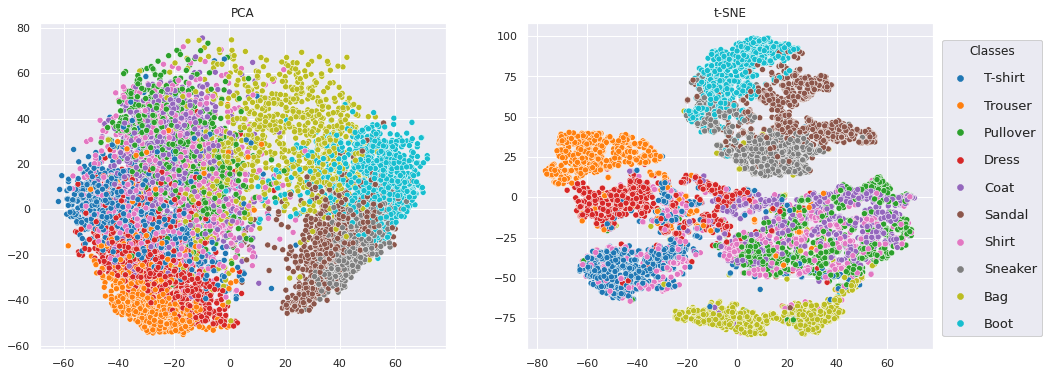

In [124]:
import seaborn as sns
sns.set_theme()

fig, axs = plt.subplots(1,2, figsize=(16, 6))
sc1 = axs[0].scatter(encoded_samples_reduced_PCA[:,0],
               encoded_samples_reduced_PCA[:,1],
               c=encoded_samples.label.to_numpy(),
            cmap="tab10", edgecolor='white', linewidths=0.5)


sc2 = axs[1].scatter(encoded_samples_reduced_TSNE[:,0],
            encoded_samples_reduced_TSNE[:,1],
            c=encoded_samples.label.to_numpy(),
            cmap="tab10", edgecolor='white', linewidths=0.5)

axs[0].set_title("PCA")
axs[1].set_title("t-SNE")
# axs[0].legend(range(10))
label_names = ['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt',
             'Sneaker','Bag','Boot']

legend1 = fig.legend(sc1.legend_elements()[0], label_names,
                    title="Classes", loc='right',
                    fontsize=13, labelspacing=1.1)
# legend2 = axs[1].legend(sc2.legend_elements()[0], label_names,
#                     loc="lower left", title="Classes")

fig.add_artist(legend1)
# .add_artist(legend2)
fig.show()

In [77]:
from matplotlib import cm
colors = cm.get_cmap("tab10"))
# encoded_samples.label.to_numpy()

(0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


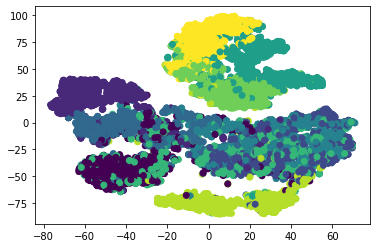

In [59]:

plt.scatter(encoded_samples_reduced_TSNE[:,0],
            encoded_samples_reduced_TSNE[:,1], c=encoded_samples.label.to_numpy())

# GAN

In [ ]:
gan_study = optuna.create_study(direction='minimize')
gan_study.optimize(GAN_objective)

[I 2022-06-21 18:16:27,451] A new study created in memory with name: no-name-c536673a-1293-4fad-abcc-f989fd1dfa22
[W 2022-06-21 18:19:35,855] Trial 0 failed, because the number of the values 2 did not match the number of the objectives 1.
[W 2022-06-21 18:23:58,407] Trial 1 failed, because the number of the values 2 did not match the number of the objectives 1.
[W 2022-06-21 18:25:35,614] Trial 2 failed, because the number of the values 2 did not match the number of the objectives 1.


In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
n_classes = len(train_dataset.targets.unique())
params = {'latent_space' : 100,
          'G_filters' : 128,
          'D_filters' : 32,
          'n_channels' : 1,
          'opt' : 'Adam',
          'lr' : 1e-4}

gan = vt.GAN(params, device)

gan.netD.apply(weights_init)
gan.netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 1, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [ ]:
criterion = nn.BCEWithLogitsLoss()

gan.to(device)
loss_history, img_list = vt.train_GAN(
    gan, train_dataloader, 50, criterion, device, saturating=False, snapshots = True)

[1/50]	Loss_D: 0.4143, 	Loss_G: 1.9899, 	D(x): 1.7801 	D(G(z)): -1.4681 / -1.8276
[2/50]	Loss_D: 0.5194, 	Loss_G: 2.4041, 	D(x): 1.7420 	D(G(z)): -1.3610 / -2.2801
[3/50]	Loss_D: 0.4489, 	Loss_G: 2.4095, 	D(x): 2.2150 	D(G(z)): -1.5505 / -2.2750
[4/50]	Loss_D: 0.0526, 	Loss_G: 4.3918, 	D(x): 4.3749 	D(G(z)): -3.9687 / -4.3742
[5/50]	Loss_D: 0.2286, 	Loss_G: 3.4725, 	D(x): 2.4779 	D(G(z)): -2.6010 / -3.4184
[6/50]	Loss_D: 0.2394, 	Loss_G: 3.0293, 	D(x): 2.6842 	D(G(z)): -2.7015 / -2.9501
[7/50]	Loss_D: 0.1142, 	Loss_G: 3.6158, 	D(x): 3.5194 	D(G(z)): -3.1496 / -3.5713
[8/50]	Loss_D: 0.2089, 	Loss_G: 3.4731, 	D(x): 2.7943 	D(G(z)): -2.8351 / -3.4284
[9/50]	Loss_D: 0.2437, 	Loss_G: 2.5964, 	D(x): 2.8177 	D(G(z)): -2.1807 / -2.4873
[10/50]	Loss_D: 0.4134, 	Loss_G: 2.3999, 	D(x): 2.1531 	D(G(z)): -1.8950 / -2.2628
[11/50]	Loss_D: 0.2468, 	Loss_G: 3.0918, 	D(x): 2.7696 	D(G(z)): -2.4226 / -3.0250
[12/50]	Loss_D: 0.5166, 	Loss_G: 2.1394, 	D(x): 1.5795 	D(G(z)): -1.7418 / -1.9571
[13/50]	Loss_

In [ ]:
gan.zero_grad()
test_data = test_dataset[0][0].unsqueeze(0).to(device)
D_out = gan.netD(test_data)

label = torch.tensor([1],
                dtype=torch.float, device=device).reshape((1,1,1,1))
    

criterion(D_out, label)

tensor(0.3994, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
rand_noise = torch.randn(64, gan.latent_space, 1, 1, device=device)

gen_fakes = gan.netG(rand_noise).cpu().detach().numpy()[0]


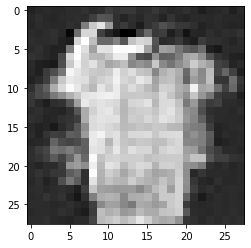

In [ ]:
plt.imshow(gen_fakes[0], cmap= 'gist_gray')

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.title('Saturating G loss')
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), cmap='gist_gray', animated=True)] for i in gen_fakes]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
class Generator(nn.Module):
    def __init__(self, params):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(params['latent_space'], params['G_filters'] * 4, 3, 2, 0, bias=False),
            nn.BatchNorm2d(params['G_filters'] * 4),
            nn.ReLU(True),
            # state size. (G_filters*8, 4, 4)
            nn.ConvTranspose2d(params['G_filters'] * 4, params['G_filters'] * 2, 3, 2, 0, bias=False),
            nn.BatchNorm2d(params['G_filters'] * 2),
            nn.ReLU(True),
            # state size. (G_filters*4, 8, 8)
            nn.ConvTranspose2d( params['G_filters'] * 2, params['G_filters'], 3, 2, 0, bias=False),
            nn.BatchNorm2d(params['G_filters']),
            nn.ReLU(True),
            # state size. (G_filters*2, 16, 16)
            nn.ConvTranspose2d( params['G_filters'], params['n_channels'], 3, 2, 2, 1, bias=False),
            nn.Tanh()
            # state size. (n_channels, 64, 64)
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(params).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
#netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 1, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, params, conditional=False):
        super(Discriminator, self).__init__()
        self.conditional=conditional
        self.main = nn.Sequential(
            # input is (1,28,28)
            nn.Conv2d(in_channels=params['n_channels'], out_channels=params['D_filters'],
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (D_filters, 14, 14)
            nn.Conv2d(in_channels=params['D_filters'], out_channels=params['D_filters'] * 2,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(params['D_filters'] * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (D_filters*2, 7, 7)
            nn.Conv2d(in_channels=params['D_filters'] * 2, out_channels=params['D_filters'] * 4,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(params['D_filters'] * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (D_filters*4, 3, 3)
            nn.Conv2d(in_channels = params['D_filters']* 4, out_channels=1,
                      kernel_size = 4, stride=2, padding=1)
            # scalar output (1, 1, 1)
        )

    def forward(self, input):
        if self.conditional:
            pass

        else:
            return self.main(input)

In [ ]:
class GAN(nn.Module):
    def __init__(self, params, device, conditional=False):
        super(GAN, self).__init__()
        self.conditional = conditional
        self.latent_space = params['latent_space']
        self.netG = Generator(params)
        self.netD = Discriminator(params, conditional = self.conditional)
        self.epochs_trained = 0
        self.device = device
        
        self.optimizerD = getattr(torch.optim, params['opt'])(self.netD.params_to_optimize(), lr=params['lr'])
        self.optimizerG = getattr(torch.optim, params['opt'])(self.netG.params_to_optimize(), lr=params['lr'])


Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)


(1, 1, 1, 1)

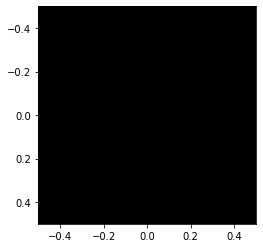

In [ ]:
# Create the Discriminator
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
netD = Discriminator(params).to(device)
img = img.to(device)
dsc_img = netD(img).detach().cpu().numpy()
img.detach()
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# netD.apply(weights_init)

# Print the model
print(netD)
plt.imshow(dsc_img[0][0], cmap='gist_gray')

dsc_img.shape

In [ ]:
# Initialize BCELoss function
criterion = nn.BCEWithLogitsLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, params['latent_space'], 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D

beta1 = 0.5
optimizerD = torch.optim.Adam(netD.parameters(), lr=params['lr'], betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=params['lr'], betas=(beta1, 0.999))

In [ ]:
getattr(torch.optim, "Adam")

torch.optim.adam.Adam

In [ ]:
# Training Loop
# Lists to keep track of progress

num_epochs = 30
img_list = []
G_losses = []
D_losses = []
iters = 0
latent_space = params['latent_space']
saturating = False

print("Starting Training Loop...")
# For each epoch
for epoch in range(1, num_epochs+1):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_space, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        if saturating:
            # Saturating loss: Use fake_label y = 0 to get J(G) = log(1−D(G(z)))
            label.fill_(fake_label)
        else:
            # Non-saturating loss: fake labels are real for generator cost
            label.fill_(real_label)

        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output

        if saturating:
            errG = -criterion(output, label)  # Saturating loss: -J(D) = J(G)
        else:
            errG = criterion(output, label)  # Non-saturating loss
        
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise

        if (iters % 500 == 0) or ((epoch == num_epochs) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        print(f'[{epoch}/{num_epochs}]\tLoss_D: {errD.item():.4f}, \tLoss_G: {errG.item():.4f}, \tD(x): {D_x:.4f} \tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}', end = '\r')
    print(f'[{epoch}/{num_epochs}]\tLoss_D: {errD.item():.4f}, \tLoss_G: {errG.item():.4f}, \tD(x): {D_x:.4f} \tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}', end = '\n')

Starting Training Loop...
[1/30]	Loss_D: 1.3878, 	Loss_G: 0.7139, 	D(x): 0.0236 	D(G(z)): 0.0184 / -0.0385
[2/30]	Loss_D: 1.3777, 	Loss_G: 0.7141, 	D(x): 0.0153 	D(G(z)): -0.0052 / -0.0402
[3/30]	Loss_D: 1.2067, 	Loss_G: 0.8927, 	D(x): -0.1324 	D(G(z)): -0.6342 / -0.3488
[4/30]	Loss_D: 1.0395, 	Loss_G: 1.0993, 	D(x): 0.4360 	D(G(z)): -0.4174 / -0.6759
[5/30]	Loss_D: 0.9452, 	Loss_G: 0.9463, 	D(x): 0.4824 	D(G(z)): -0.6217 / -0.4139
[6/30]	Loss_D: 0.8098, 	Loss_G: 0.8868, 	D(x): 0.3327 	D(G(z)): -1.3411 / -0.3264
[7/30]	Loss_D: 0.8609, 	Loss_G: 1.2462, 	D(x): 0.9594 	D(G(z)): -0.4758 / -0.8872
[8/30]	Loss_D: 0.8652, 	Loss_G: 0.9858, 	D(x): 0.5119 	D(G(z)): -0.9138 / -0.4751
[9/30]	Loss_D: 0.8863, 	Loss_G: 0.9549, 	D(x): 0.2619 	D(G(z)): -1.2449 / -0.4176
[10/30]	Loss_D: 0.8801, 	Loss_G: 1.0184, 	D(x): 0.0411 	D(G(z)): -1.8647 / -0.5207
[11/30]	Loss_D: 0.8700, 	Loss_G: 2.2142, 	D(x): 1.7060 	D(G(z)): -0.1106 / -2.0702
[12/30]	Loss_D: 0.5161, 	Loss_G: 1.6426, 	D(x): 1.3657 	D(G(z)): -1.38

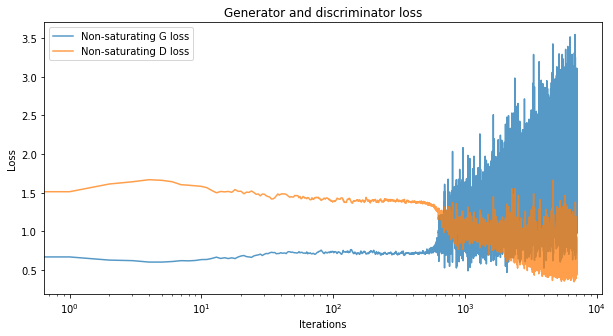

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and discriminator loss")
plt.plot(G_losses,label="Non-saturating G loss", alpha=0.75)
plt.plot(D_losses,label="Non-saturating D loss", alpha=0.75)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.xscale("log")
plt.legend()
plt.show()

In [ ]:
# Visualize results with saturating G loss
fig = plt.figure(figsize=(8,8))
plt.title('Saturating G loss')
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

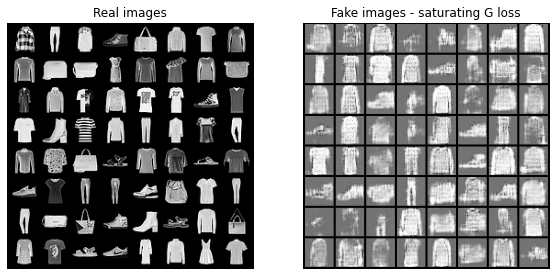

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.axis("off")
plt.title("Real images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,3,2)
plt.axis("off")
plt.title("Fake images - saturating G loss")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

In [ ]:
# Training Loop
saturating = False
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_space, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################


        if saturating:
            label.fill_(fake_label) # Saturating loss: Use fake_label y = 0 to get J(G) = log(1−D(G(z)))
        else:
            label.fill_(real_label) # Non-saturating loss: fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        
        if saturating:
            errG = -criterion(output, label) # Saturating loss: -J(D) = J(G)
        else:
            errG = criterion(output, label) # Non-saturating loss

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)